In [483]:
import dgl
import dgl.data
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.sparse as sp
import torch
import torch.nn as nn
import scipy.io as sio
import random
import copy
import time

# Test dgl draw graph

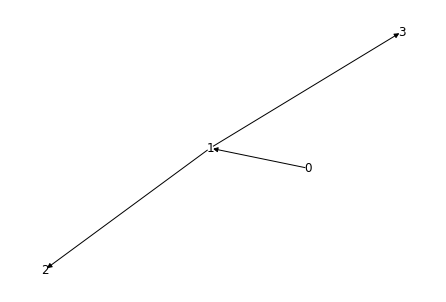

In [311]:
# dataset = dgl.data.CoraGraphDataset()
# test_graph = dataset[0]

graph_src = np.array([0, 1, 1], dtype=np.int32)
graph_dst = np.array([1, 2, 3], dtype=np.int32)
test_graph = dgl.graph((graph_src, graph_dst))

options = {
    'node_color': 'white',
    'node_size': 30,
    'width': 1,
    'with_labels': True
}
G = dgl.to_networkx(test_graph)
plt.figure(figsize=[6,4])
nx.draw(G, **options)

# Generate Testing Graph

In [312]:
N = 10
EdgeSelectRatio = 0.3

np.random.seed(10)

edge_pair = [(i // N, i % N) for i in range(N ** 2) if i // N > i % N]
selected_edges = np.array(edge_pair)[np.random.choice(np.arange(len(edge_pair)), size=int(EdgeSelectRatio * len(edge_pair)), replace=False)]
selected_edges = np.concatenate([selected_edges, selected_edges[:, ::-1]], axis=0)

graph = dgl.DGLGraph((selected_edges[:, 0], selected_edges[:, 1]))

G:\GNN\Graph-Group-Discrimination-main\venv\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


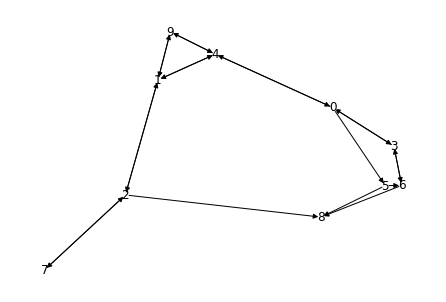

In [612]:
options = {
    'node_color': 'white',
    'node_size': 30,
    'width': 1,
    'with_labels': True
}
G_NWX = dgl.to_networkx(graph)
plt.figure(figsize=[6,4])
nx.draw_spectral(G_NWX, **options)

# TEST: Random walk with prob = 1

In [314]:
# subgraph_size = 4
# 
# traces = dgl.contrib.sampling.random_walk_with_restart(
#     graph, list(range(N)), 
#     restart_prob=1, 
#     max_nodes_per_seed=subgraph_size*3)


# node_dict = {}
# for i in range(len(traces)):
#     trace = traces[i]
#     node_set = set()
#     for node in trace:
#         node_set.add(node.item())
#     node_dict[i] = node_set


# node_start = 1
# sampled_nodes = node_dict[node_start]

def draw_subgraph(G_NWX, node_start, sampled_nodes):
    node_color_map = []
    for node in range(len(G_NWX.nodes)):
        if node in sampled_nodes:
            node_color_map.append("pink")
        elif node == node_start:
            node_color_map.append("red")
        else: 
            node_color_map.append("white")
    subgraph_nodes = {node_start}
    for e in sampled_nodes:
        subgraph_nodes.add(e)
    edge_color_map = []
    for u, v in G_NWX.edges():
        if u in subgraph_nodes and v in subgraph_nodes:
            edge_color_map.append("salmon")
        else:
            edge_color_map.append("gray")
        
    options = {
        'node_color': 'white',
        'node_size': 30,
        'font_size': 8,
        'width': 1,
        'with_labels': True,
        'node_color': node_color_map,
        'edge_color': edge_color_map
    }
    nx.draw_spectral(G_NWX, **options)

# draw graph with different ratio
# FIG_W = 5
# FIG_H = 2
# plt.figure(figsize=[2*FIG_W,2*FIG_H])
# 
# for node in range(N):
#     plt.subplot(FIG_H, FIG_W, node + 1)
#     draw_subgraph(G_NWX, node, node_dict[node])
# plt.savefig("Random Sampling with restart_ratio=1", dpi=400)


# Read Cora for testing

In [ ]:
from utils import *
adj, features, labels, idx_train, idx_val, idx_test, ano_label, str_ano_label, attr_ano_label = load_mat("cora")
features, _ = preprocess_features(features)
src, dst = np.nonzero(adj)
g_cora = dgl.graph((src, dst))
g_cora.ndata['feat'] = torch.FloatTensor(features)
g_cora.ndata['label'] = torch.LongTensor(labels)
g_cora_cuda = g_cora.to('cuda')

In [597]:
class GraphSamplerTEST(torch.nn.Module):
    def __init__(self, graph, n_nodes=4):
        super(GraphSamplerTEST, self).__init__()
        # GCN: A @ X @ W
        self.g = graph
        device = graph.device
        A = self.g.adjacency_matrix()
        
        # TEST 1: create new graph then send it to device
        indices_list = []
        probs_list = []
        
        for i in range(self.g.num_nodes()):
            row = A[i]._indices()
            size = row.size()[1]
            tensor_ones = torch.ones(size)
            indices = torch.cat([tensor_ones.unsqueeze(0) * i, row], dim=0)
            indices_list.append(indices)
            if size < n_nodes: 
                probs_list.append(tensor_ones)
            else:
                dropout_prob = n_nodes / size
                probs_list.append(tensor_ones * dropout_prob)
        probs = torch.cat(probs_list)
        self.sampler = torch.distributions.bernoulli.Bernoulli(probs=probs)
        self.indices = torch.cat(indices_list, dim=1).to(torch.int32)
        
        # TEST 2: deep copy the graph, then drop edges using index
        
        probs_src = []
        for i in range(self.g.num_nodes()):
            row = A[i]._indices()
            size = row.size()[1]
            if size < n_nodes: 
                probs_src.append(1)
            else:
                dropout_prob = n_nodes / size
                probs_src.append(dropout_prob)
        probs_src = torch.tensor(probs_src)
        adj_indices = graph.adjacency_matrix()._indices()[0]
        edge_drop_prob = 1 - probs_src[adj_indices]
        self.sampler_dropedges = torch.distributions.bernoulli.Bernoulli(probs=edge_drop_prob.to(device))
        
    def forward_copy(self, training=True):
        graph = copy.deepcopy(self.g) # 0.38
        # select dropped edges
        selected_edges = self.sampler_dropedges.sample() # 0.41
        index = selected_edges.nonzero().squeeze() # 0.60
        graph.remove_edges(index) # 1.52
        
        return graph
    
    def forward_create(self, training=True):
        new_indices = torch.masked_select(
            self.indices, 
            self.sampler.sample().to(torch.bool)
        ).reshape((2, -1))
        # 0.25823497772216797
        graph = dgl.graph((new_indices[0, :], new_indices[1, :]), num_nodes= self.g.num_nodes())
        graph = graph.to(self.g.device)
        # 0.5955414772033691
        if 'feat' in self.g.ndata:
            graph.ndata['feat'] = self.g.ndata['feat']
        if 'label' in self.g.ndata:
            graph.ndata['label'] = self.g.ndata['label']
        # 0.6195650100708008
        return graph

In [600]:
graph_sampler = GraphSamplerTEST(g_cora_cuda, n_nodes=4)
n_sampling = 1000

t_create_start = time.time()
for i in range(n_sampling):
    cora_drop_create = graph_sampler.forward_create()
t_create_end = time.time()
t_create_delta = t_create_end - t_create_start
print(t_create_delta)
print(cora_drop_create)
print(cora_drop_create.device)
 
# no if : 5.638128042221069
# if: 5.629454851150513


0.6075518131256104


In [599]:

graph_sampler = GraphSamplerTEST(g_cora_cuda, n_nodes=4)
n_sampling = 1000
t_copy_start = time.time()
for i in range(n_sampling):
    cora_drop_copy = graph_sampler.forward_copy()
t_copy_end = time.time()
t_copy_delta = t_copy_end - t_copy_start
print(t_copy_delta)

1.5183818340301514
Graph(num_nodes=2708, num_edges=7716,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(6,), dtype=torch.int64)}
      edata_schemes={})
cuda:0


# Create a new graph 跑得更快 (0.6 vs 1.5)

In [631]:

class GraphSampler(torch.nn.Module):
    def __init__(self, graph, n_nodes=4):
        super(GraphSampler, self).__init__()
        self.g = graph
        
        indices_list = []
        probs_list = []
        
        A = self.g.adjacency_matrix()
        for i in range(self.g.num_nodes()):
            row = A[i]._indices()
            size = row.size()[1]
            tensor_ones = torch.ones(size)
            indices = torch.cat([tensor_ones.unsqueeze(0) * i, row], dim=0)
            indices_list.append(indices)
            if size < n_nodes: 
                probs_list.append(tensor_ones)
            else:
                dropout_prob = n_nodes / size
                probs_list.append(tensor_ones * dropout_prob)
        probs = torch.cat(probs_list)
        self.sampler = torch.distributions.bernoulli.Bernoulli(probs=probs.to(self.g.device))
        self.indices = torch.cat(indices_list, dim=1).to(torch.int32).to(self.g.device)
        
    def sample(self):
        new_indices = torch.masked_select(
            self.indices, 
            self.sampler.sample().to(torch.bool)
        ).reshape((2, -1))
        graph = dgl.graph((new_indices[0, :], new_indices[1, :]), num_nodes= self.g.num_nodes())
        if 'feat' in self.g.ndata:
            graph.ndata['feat'] = self.g.ndata['feat']
        if 'label' in self.g.ndata:
            graph.ndata['label'] = self.g.ndata['label']
        return graph


# viusualization

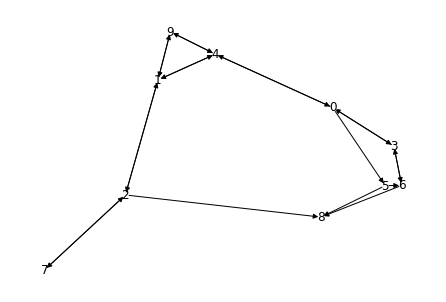

In [613]:
# Raw graph

options = {
    'node_color': 'white',
    'node_size': 30,
    'width': 1,
    'with_labels': True
}
G_NWX = dgl.to_networkx(graph)
plt.figure(figsize=[6,4])
nx.draw_spectral(G_NWX, **options)

In [632]:
graph_sampler =  GraphSampler(graph, n_nodes=2)

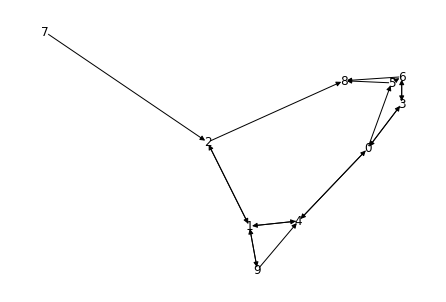

In [635]:
# dropped 


options = {
    'node_color': 'white',
    'node_size': 30,
    'width': 1,
    'with_labels': True
}
G_NWX = dgl.to_networkx(graph_sampler.sample())
plt.figure(figsize=[6,4])
nx.draw_spectral(G_NWX, **options)







